In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuração de plotagem
plt.style.use('default')
%matplotlib inline

In [62]:
# Baixando dados do IBOVESPA
ticker = '^BVSP'
start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')
end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

print("Baixando dados do IBOVESPA...")
data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
ibov = data.droplevel(1, axis=1)

[*********************100%***********************]  1 of 1 completed

Baixando dados do IBOVESPA...


In [63]:
def calculate_rsi(prices, window=2):
    """Calcula o RSI (Relative Strength Index) usando Wilder's smoothing"""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Primeira média (simples) para os primeiros 'window' períodos
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    
    # Aplicar Wilder's smoothing para os períodos subsequentes
    for i in range(window, len(gain)):
        avg_gain.iloc[i] = (avg_gain.iloc[i-1] * (window-1) + gain.iloc[i]) / window
        avg_loss.iloc[i] = (avg_loss.iloc[i-1] * (window-1) + loss.iloc[i]) / window
    
    # Calcular RS e RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi




try:
    import pandas_ta as ta
    print("pandas-ta já está instalado")
except ImportError:
    print("Instalando pandas-ta...")
    import subprocess
    subprocess.check_call(["pip", "install", "pandas-ta"])
    import pandas_ta as ta

# Comparando nossa implementação com a biblioteca padrão
ibov['rsi_lib'] = ta.rsi(ibov['Close'], length=2)
ibov['rsi'] = ibov['rsi_lib']

# Comparação visual
print("\nComparação RSI (primeiros 20 valores):")
comparison = pd.DataFrame({
    'Close': ibov['Close'].head(20),
    'RSI_nossa': ibov['rsi'].head(20),
    'RSI_lib': ibov['rsi_lib'].head(20)
})
print(comparison.round(2))

# Verificar correlação
correlation = ibov[['rsi', 'rsi_lib']].corr().iloc[0,1]
print(f"\nCorrelação entre implementações: {correlation:.4f}")

# Usar a implementação da biblioteca para o backtesting (mais confiável)
ibov = ibov.drop('rsi_lib', axis=1)

ibov['rsi'] = calculate_rsi(ibov['Close'])
ibov = ibov.dropna()

print(f"Período analisado: {ibov.index[0].strftime('%d/%m/%Y')} a {ibov.index[-1].strftime('%d/%m/%Y')}")
print(f"Total de observações: {len(ibov)}")


pandas-ta já está instalado

Comparação RSI (primeiros 20 valores):
                 Close  RSI_nossa  RSI_lib
Date                                      
2020-09-17 100098.0000        NaN      NaN
2020-09-18  98290.0000     0.0000   0.0000
2020-09-21  96991.0000     0.0000   0.0000
2020-09-22  97294.0000    16.3200  16.3200
2020-09-23  95735.0000     6.0900   6.0900
2020-09-24  97012.0000    53.6700  53.6700
2020-09-25  96999.0000    53.1200  53.1200
2020-09-28  94666.0000    11.3900  11.3900
2020-09-29  93580.0000     6.5800   6.5800
2020-09-30  94603.0000    47.9800  47.9800
2020-10-01  95479.0000    70.4300  70.4300
2020-10-02  94016.0000    28.8500  28.8500
2020-10-05  96089.0000    73.3800  73.3800
2020-10-06  95615.0000    57.0500  57.0500
2020-10-07  95526.0000    52.6500  52.6500
2020-10-08  97920.0000    90.8000  90.8000
2020-10-09  97483.0000    70.1600  70.1600
2020-10-13  98503.0000    85.5200  85.5200
2020-10-14  99334.0000    92.1300  92.1300
2020-10-15  99054.0000    70.

In [64]:
class RSIBacktester:
    def __init__(self, data, initial_capital=1_000_000, cdi_rate=0.10):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.cdi_rate = cdi_rate
        self.daily_cdi_rate = (1 + cdi_rate) ** (1/252) - 1  # CDI diário
        
        # Variáveis de controle
        self.cash = initial_capital
        self.position = 0
        self.entry_price = 0
        
        # Listas para armazenar resultados
        self.portfolio_values = []
        self.trades = []
        self.daily_returns = []
        
    def run_backtest(self):
        """Executa o backtesting da estratégia RSI(2)"""
        print("Executando backtesting...")
        
        for i, (date, row) in enumerate(self.data.iterrows()):
            price = row['Close']
            rsi = row['rsi']
            
            # Aplica rendimento CDI no dinheiro em caixa (apenas se não tem posição)
            if self.position == 0:
                self.cash *= (1 + self.daily_cdi_rate)
            
            # Sinal de entrada: RSI <= 10 e sem posição
            if rsi <= 10 and self.position == 0:
                self.position = int(self.cash // price)
                cost = self.position * price
                self.cash -= cost
                self.entry_price = price
                
                # Registra o trade
                trade = {
                    'entry_date': date,
                    'entry_price': price,
                    'entry_rsi': rsi,
                    'type': 'BUY'
                }
                self.trades.append(trade)
            
            # Sinal de saída: RSI >= 80 e com posição
            elif rsi >= 80 and self.position > 0:
                revenue = self.position * price
                self.cash += revenue
                
                # Completa o trade anterior
                if self.trades and 'exit_date' not in self.trades[-1]:
                    self.trades[-1].update({
                        'exit_date': date,
                        'exit_price': price,
                        'exit_rsi': rsi,
                        'quantity': self.position,
                        'profit': revenue - (self.position * self.entry_price),
                        'return_pct': (price - self.entry_price) / self.entry_price * 100
                    })
                
                self.position = 0
                self.entry_price = 0
            
            # Calcula valor do portfólio (Mark to Market)
            portfolio_value = self.cash + (self.position * price)
            self.portfolio_values.append(portfolio_value)
            
            # Calcula retorno diário
            if i > 0:
                daily_return = (portfolio_value - self.portfolio_values[i-1]) / self.portfolio_values[i-1]
                self.daily_returns.append(daily_return)
        
        # Fecha posição em aberto se existir
        if self.position > 0:
            final_price = self.data['Close'].iloc[-1]
            revenue = self.position * final_price
            self.cash += revenue
            
            if self.trades and 'exit_date' not in self.trades[-1]:
                self.trades[-1].update({
                    'exit_date': self.data.index[-1],
                    'exit_price': final_price,
                    'exit_rsi': self.data['rsi'].iloc[-1],
                    'quantity': self.position,
                    'profit': revenue - (self.position * self.entry_price),
                    'return_pct': (final_price - self.entry_price) / self.entry_price * 100
                })
            
            self.position = 0
            self.portfolio_values[-1] = self.cash
        
        print(f"Backtesting concluído! Total de trades: {len([t for t in self.trades if 'exit_date' in t])}")
        
    def calculate_metrics(self):
        """Calcula todas as métricas solicitadas"""
        completed_trades = [t for t in self.trades if 'exit_date' in t]
        
        if not completed_trades:
            print("Nenhum trade completo encontrado!")
            return {}
        
        # Dados básicos
        final_value = self.portfolio_values[-1]
        total_return_pct = (final_value - self.initial_capital) / self.initial_capital * 100
        
        # PROFITABILITY METRICS
        total_pnl = final_value - self.initial_capital
        number_of_trades = len(completed_trades)
        
        # Trades vencedores e perdedores
        winning_trades = [t for t in completed_trades if t['profit'] > 0]
        losing_trades = [t for t in completed_trades if t['profit'] <= 0]
        
        accuracy = len(winning_trades) / number_of_trades * 100 if number_of_trades > 0 else 0
        
        avg_return_per_trade = np.mean([t['return_pct'] for t in completed_trades]) if completed_trades else 0
        avg_winning_return = np.mean([t['return_pct'] for t in winning_trades]) if winning_trades else 0
        avg_losing_return = np.mean([t['return_pct'] for t in losing_trades]) if losing_trades else 0
        
        win_loss_ratio = abs(avg_winning_return / avg_losing_return) if avg_losing_return != 0 else float('inf')
        
        # CAGR
        days = (self.data.index[-1] - self.data.index[0]).days
        cagr = (final_value / self.initial_capital) ** (252 / days) - 1
        
        # RISK METRICS
        returns_array = np.array(self.daily_returns) if self.daily_returns else np.array([0])
        portfolio_values_array = np.array(self.portfolio_values)
        
        # Maximum Drawdown
        peak = np.maximum.accumulate(portfolio_values_array)
        drawdown = (portfolio_values_array - peak) / peak
        max_drawdown = np.min(drawdown) * 100
        
        # Volatilidade
        volatility = np.std(returns_array) * np.sqrt(252) * 100 if len(returns_array) > 1 else 0
        
        # Average Recovery Time (simplificado)
        # Calcula quantos dias leva para recuperar dos drawdowns
        recovery_times = []
        in_drawdown = False
        drawdown_start = 0
        
        for i, dd in enumerate(drawdown):
            if dd < -0.01 and not in_drawdown:  # Início de drawdown > 1%
                in_drawdown = True
                drawdown_start = i
            elif dd >= 0 and in_drawdown:  # Recuperação completa
                recovery_times.append(i - drawdown_start)
                in_drawdown = False
        
        avg_recovery_time = np.mean(recovery_times) if recovery_times else 0
        
        # PERFORMANCE METRICS
        risk_free_rate = self.cdi_rate  # CDI como taxa livre de risco
        excess_return = cagr - risk_free_rate
        
        # Sharpe Ratio
        sharpe_ratio = excess_return / (volatility / 100) if volatility > 0 else 0
        
        # Sortino Ratio
        negative_returns = returns_array[returns_array < risk_free_rate / 252]
        downside_deviation = np.std(negative_returns) * np.sqrt(252) if len(negative_returns) > 0 else 0.01
        sortino_ratio = excess_return / downside_deviation if downside_deviation > 0 else 0
        
        # Calmar Ratio
        calmar_ratio = (cagr * 100) / abs(max_drawdown) if max_drawdown < 0 else 0
        
        metrics = {
            # Profitability Metrics
            'Total PnL (R$)': total_pnl,
            'Total Return (%)': total_return_pct,
            'CAGR (%)': cagr * 100,
            'Number of Trades': number_of_trades,
            'Accuracy (%)': accuracy,
            'Average Return per Trade (%)': avg_return_per_trade,
            'Average Winning Return (%)': avg_winning_return,
            'Average Losing Return (%)': avg_losing_return,
            'Win/Loss Ratio': win_loss_ratio,
            
            # Risk Metrics
            'Maximum Drawdown (%)': max_drawdown,
            'Volatility (% anual)': volatility,
            'Average Recovery Time (days)': avg_recovery_time,
            
            # Performance Metrics
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Calmar Ratio': calmar_ratio
        }
        
        return metrics
    
    def plot_results(self):
        """Gera gráficos completos dos resultados"""
        fig, axes = plt.subplots(3, 3, figsize=(20, 16))
        
        dates = self.data.index
        
        # 1. Evolução do Portfólio
        axes[0, 0].plot(dates, self.portfolio_values, 'b-', linewidth=2, label='Estratégia RSI(2)')
        axes[0, 0].axhline(y=self.initial_capital, color='r', linestyle='--', alpha=0.7, label='Capital Inicial')
        axes[0, 0].set_title('Evolução do Valor do Portfólio')
        axes[0, 0].set_ylabel('Valor (R$)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Preço do IBOV e RSI
        ax2_1 = axes[0, 1]
        ax2_2 = ax2_1.twinx()
        
        ax2_1.plot(dates, self.data['Close'], 'k-', linewidth=1, label='IBOV')
        ax2_2.plot(dates, self.data['rsi'], 'orange', linewidth=1, label='RSI(2)')
        ax2_2.axhline(y=10, color='g', linestyle='--', alpha=0.7, label='Compra (RSI≤10)')
        ax2_2.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='Venda (RSI≥80)')
        
        ax2_1.set_ylabel('Preço IBOV', color='k')
        ax2_2.set_ylabel('RSI', color='orange')
        ax2_1.set_title('IBOV vs RSI(2)')
        
        # 3. **NOVO: Comparação com CDI e Benchmarks**
        portfolio_returns = np.array(self.portfolio_values) / self.initial_capital
        bnh_returns = self.data['Close'] / self.data['Close'].iloc[0]
        
        # Calcular CDI acumulado
        cdi_daily = (1.10) ** (1/252) - 1  # CDI 10% a.a.
        days_elapsed = np.arange(len(dates))
        cdi_accumulated = (1 + cdi_daily) ** days_elapsed
        
        axes[0, 2].plot(dates, (portfolio_returns - 1) * 100, 'b-', linewidth=2, label='Estratégia RSI(2)')
        axes[0, 2].plot(dates, (bnh_returns - 1) * 100, 'gray', linewidth=2, label='Buy & Hold IBOV')
        axes[0, 2].plot(dates, (cdi_accumulated - 1) * 100, 'green', linewidth=2, label='CDI 10% a.a.')
        axes[0, 2].set_title('Retorno Acumulado: Estratégia vs Benchmarks')
        axes[0, 2].set_ylabel('Retorno Acumulado (%)')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Drawdown
        portfolio_values_array = np.array(self.portfolio_values)
        peak = np.maximum.accumulate(portfolio_values_array)
        drawdown = (portfolio_values_array - peak) / peak * 100
        
        axes[1, 0].fill_between(dates, drawdown, 0, color='red', alpha=0.3)
        axes[1, 0].plot(dates, drawdown, 'r-', linewidth=1)
        axes[1, 0].set_title('Drawdown (%)')
        axes[1, 0].set_ylabel('Drawdown (%)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 5. **NOVO: Comparação de Drawdowns**
        bnh_peak = np.maximum.accumulate(self.data['Close'].values)
        bnh_drawdown = (self.data['Close'].values - bnh_peak) / bnh_peak * 100
        
        axes[1, 1].plot(dates, drawdown, 'b-', linewidth=2, label='Estratégia RSI(2)')
        axes[1, 1].plot(dates, bnh_drawdown, 'gray', linewidth=2, label='Buy & Hold')
        axes[1, 1].fill_between(dates, drawdown, 0, color='blue', alpha=0.2)
        axes[1, 1].fill_between(dates, bnh_drawdown, 0, color='gray', alpha=0.2)
        axes[1, 1].set_title('Comparação de Drawdowns')
        axes[1, 1].set_ylabel('Drawdown (%)')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # 6. **NOVO: Retorno em Excesso vs CDI**
        portfolio_daily_returns = np.diff(self.portfolio_values) / self.portfolio_values[:-1]
        excess_returns_vs_cdi = (portfolio_daily_returns - cdi_daily) * 100
        
        axes[1, 2].plot(dates[1:], np.cumsum(excess_returns_vs_cdi), 'purple', linewidth=2)
        axes[1, 2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[1, 2].fill_between(dates[1:], np.cumsum(excess_returns_vs_cdi), 0, 
                            where=(np.cumsum(excess_returns_vs_cdi) >= 0), 
                            color='green', alpha=0.3, label='Outperformance')
        axes[1, 2].fill_between(dates[1:], np.cumsum(excess_returns_vs_cdi), 0, 
                            where=(np.cumsum(excess_returns_vs_cdi) < 0), 
                            color='red', alpha=0.3, label='Underperformance')
        axes[1, 2].set_title('Retorno em Excesso vs CDI (Acumulado)')
        axes[1, 2].set_ylabel('Excess Return (%)')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        # 7. Distribuição dos Retornos dos Trades
        completed_trades = [t for t in self.trades if 'exit_date' in t]
        if completed_trades:
            trade_returns = [t['return_pct'] for t in completed_trades]
            axes[2, 0].hist(trade_returns, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
            axes[2, 0].axvline(x=np.mean(trade_returns), color='r', linestyle='--', 
                            label=f'Média: {np.mean(trade_returns):.2f}%')
            axes[2, 0].set_title('Distribuição dos Retornos por Trade')
            axes[2, 0].set_xlabel('Retorno (%)')
            axes[2, 0].set_ylabel('Frequência')
            axes[2, 0].legend()
            axes[2, 0].grid(True, alpha=0.3)
        

        # 11. Pontos de Entrada e Saída
        axes[2, 1].plot(dates, self.data['Close'], 'k-', linewidth=1, alpha=0.7, label='IBOV')
        
        # Marcar pontos de entrada e saída
        for trade in completed_trades:
            entry_date = trade['entry_date']
            exit_date = trade['exit_date']
            entry_price = trade['entry_price']
            exit_price = trade['exit_price']
            
            axes[2, 1].scatter(entry_date, entry_price, color='green', marker='^', s=100, alpha=0.8)
            axes[2, 1].scatter(exit_date, exit_price, color='red', marker='v', s=100, alpha=0.8)
        
        if completed_trades:
            axes[2, 1].scatter([], [], color='green', marker='^', s=100, label='Entrada')
            axes[2, 1].scatter([], [], color='red', marker='v', s=100, label='Saída')
        
        axes[2, 1].set_title('Pontos de Entrada e Saída')
        axes[2, 1].set_ylabel('Preço')
        axes[2, 1].legend()
        axes[2, 1].grid(True, alpha=0.3)
        
        # 12. **NOVO: Underwater Plot (Tempo em Drawdown)**
        underwater_periods = []
        current_underwater = 0
        
        for dd in drawdown:
            if dd < 0:
                current_underwater += 1
            else:
                if current_underwater > 0:
                    underwater_periods.append(current_underwater)
                current_underwater = 0
        
        if underwater_periods:
            axes[2, 2].hist(underwater_periods, bins=20, edgecolor='black', alpha=0.7, color='lightcoral')
            axes[2, 2].axvline(x=np.mean(underwater_periods), color='red', linestyle='--', 
                            label=f'Média: {np.mean(underwater_periods):.1f} dias')
            axes[2, 2].set_title('Distribuição: Tempo em Drawdown')
            axes[2, 2].set_xlabel('Dias em Drawdown')
            axes[2, 2].set_ylabel('Frequência')
            axes[2, 2].legend()
            axes[2, 2].grid(True, alpha=0.3)
        else:
            axes[2, 2].text(0.5, 0.5, 'Sem períodos\nem drawdown', 
                        ha='center', va='center', transform=axes[2, 2].transAxes)
            axes[2, 2].set_title('Distribuição: Tempo em Drawdown')
        
        plt.tight_layout()
        plt.show()

    # Método auxiliar para calcular métricas adicionais
    def calculate_additional_metrics(self):
        """Calcula métricas adicionais para comparação"""
        cdi_daily = (1.10) ** (1/252) - 1
        portfolio_daily_returns = np.diff(self.portfolio_values) / self.portfolio_values[:-1]
        
        # Correlação com IBOV
        ibov_returns = self.data['Close'].pct_change().dropna()
        if len(portfolio_daily_returns) == len(ibov_returns):
            correlation_with_ibov = np.corrcoef(portfolio_daily_returns, ibov_returns)[0, 1]
        else:
            correlation_with_ibov = np.nan
        
        # Beta vs IBOV
        if not np.isnan(correlation_with_ibov) and np.std(ibov_returns) > 0:
            beta = correlation_with_ibov * (np.std(portfolio_daily_returns) / np.std(ibov_returns))
        else:
            beta = np.nan
        
        # Tracking Error vs CDI
        excess_returns = portfolio_daily_returns - cdi_daily
        tracking_error = np.std(excess_returns) * np.sqrt(252) * 100
        
        # Information Ratio vs CDI
        if tracking_error > 0:
            information_ratio = np.mean(excess_returns) * 252 / (tracking_error / 100)
        else:
            information_ratio = np.nan
        
        print(f"\n📊 MÉTRICAS ADICIONAIS:")
        print(f"Correlação com IBOV: {correlation_with_ibov:.3f}")
        print(f"Beta vs IBOV: {beta:.3f}")
        print(f"Tracking Error vs CDI: {tracking_error:.2f}%")
        print(f"Information Ratio vs CDI: {information_ratio:.3f}")
        
        return {
            'correlation_ibov': correlation_with_ibov,
            'beta_ibov': beta,
            'tracking_error_cdi': tracking_error,
            'information_ratio_cdi': information_ratio
        }

In [65]:
backtester = RSIBacktester(ibov)
backtester.run_backtest()

# Calculando métricas
metrics = backtester.calculate_metrics()



Executando backtesting...
Backtesting concluído! Total de trades: 52


In [66]:
print("RELATÓRIO DE PERFORMANCE - ESTRATÉGIA RSI(2)")
print("="*60)

print("\nPROFITABILITY METRICS:")
print(f"Total PnL: R$ {metrics['Total PnL (R$)']:,.2f}")
print(f"Total Return: {metrics['Total Return (%)']:.2f}%")
print(f"CAGR: {metrics['CAGR (%)']:.2f}%")
print(f"Number of Trades: {metrics['Number of Trades']}")
print(f"Accuracy (Hit Rate): {metrics['Accuracy (%)']:.2f}%")
print(f"Average Return per Trade: {metrics['Average Return per Trade (%)']:.2f}%")
print(f"Average Winning Return: {metrics['Average Winning Return (%)']:.2f}%")
print(f"Average Losing Return: {metrics['Average Losing Return (%)']:.2f}%")
print(f"Win/Loss Ratio: {metrics['Win/Loss Ratio']:.2f}")

print("\n RISK METRICS:")
print(f"Maximum Drawdown: {metrics['Maximum Drawdown (%)']:.2f}%")
print(f"Volatility (anualizada): {metrics['Volatility (% anual)']:.2f}%")
print(f"Average Recovery Time: {metrics['Average Recovery Time (days)']:.1f} dias")

print("\nPERFORMANCE METRICS:")
print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
print(f"Sortino Ratio: {metrics['Sortino Ratio']:.2f}")
print(f"Calmar Ratio: {metrics['Calmar Ratio']:.2f}")

RELATÓRIO DE PERFORMANCE - ESTRATÉGIA RSI(2)

PROFITABILITY METRICS:
Total PnL: R$ 1,003,100.37
Total Return: 100.31%
CAGR: 10.10%
Number of Trades: 52
Accuracy (Hit Rate): 73.08%
Average Return per Trade: 0.81%
Average Winning Return: 2.03%
Average Losing Return: -2.50%
Win/Loss Ratio: 0.81

 RISK METRICS:
Maximum Drawdown: -17.33%
Volatility (anualizada): 10.38%
Average Recovery Time: 29.0 dias

PERFORMANCE METRICS:
Sharpe Ratio: 0.01
Sortino Ratio: 0.01
Calmar Ratio: 0.58


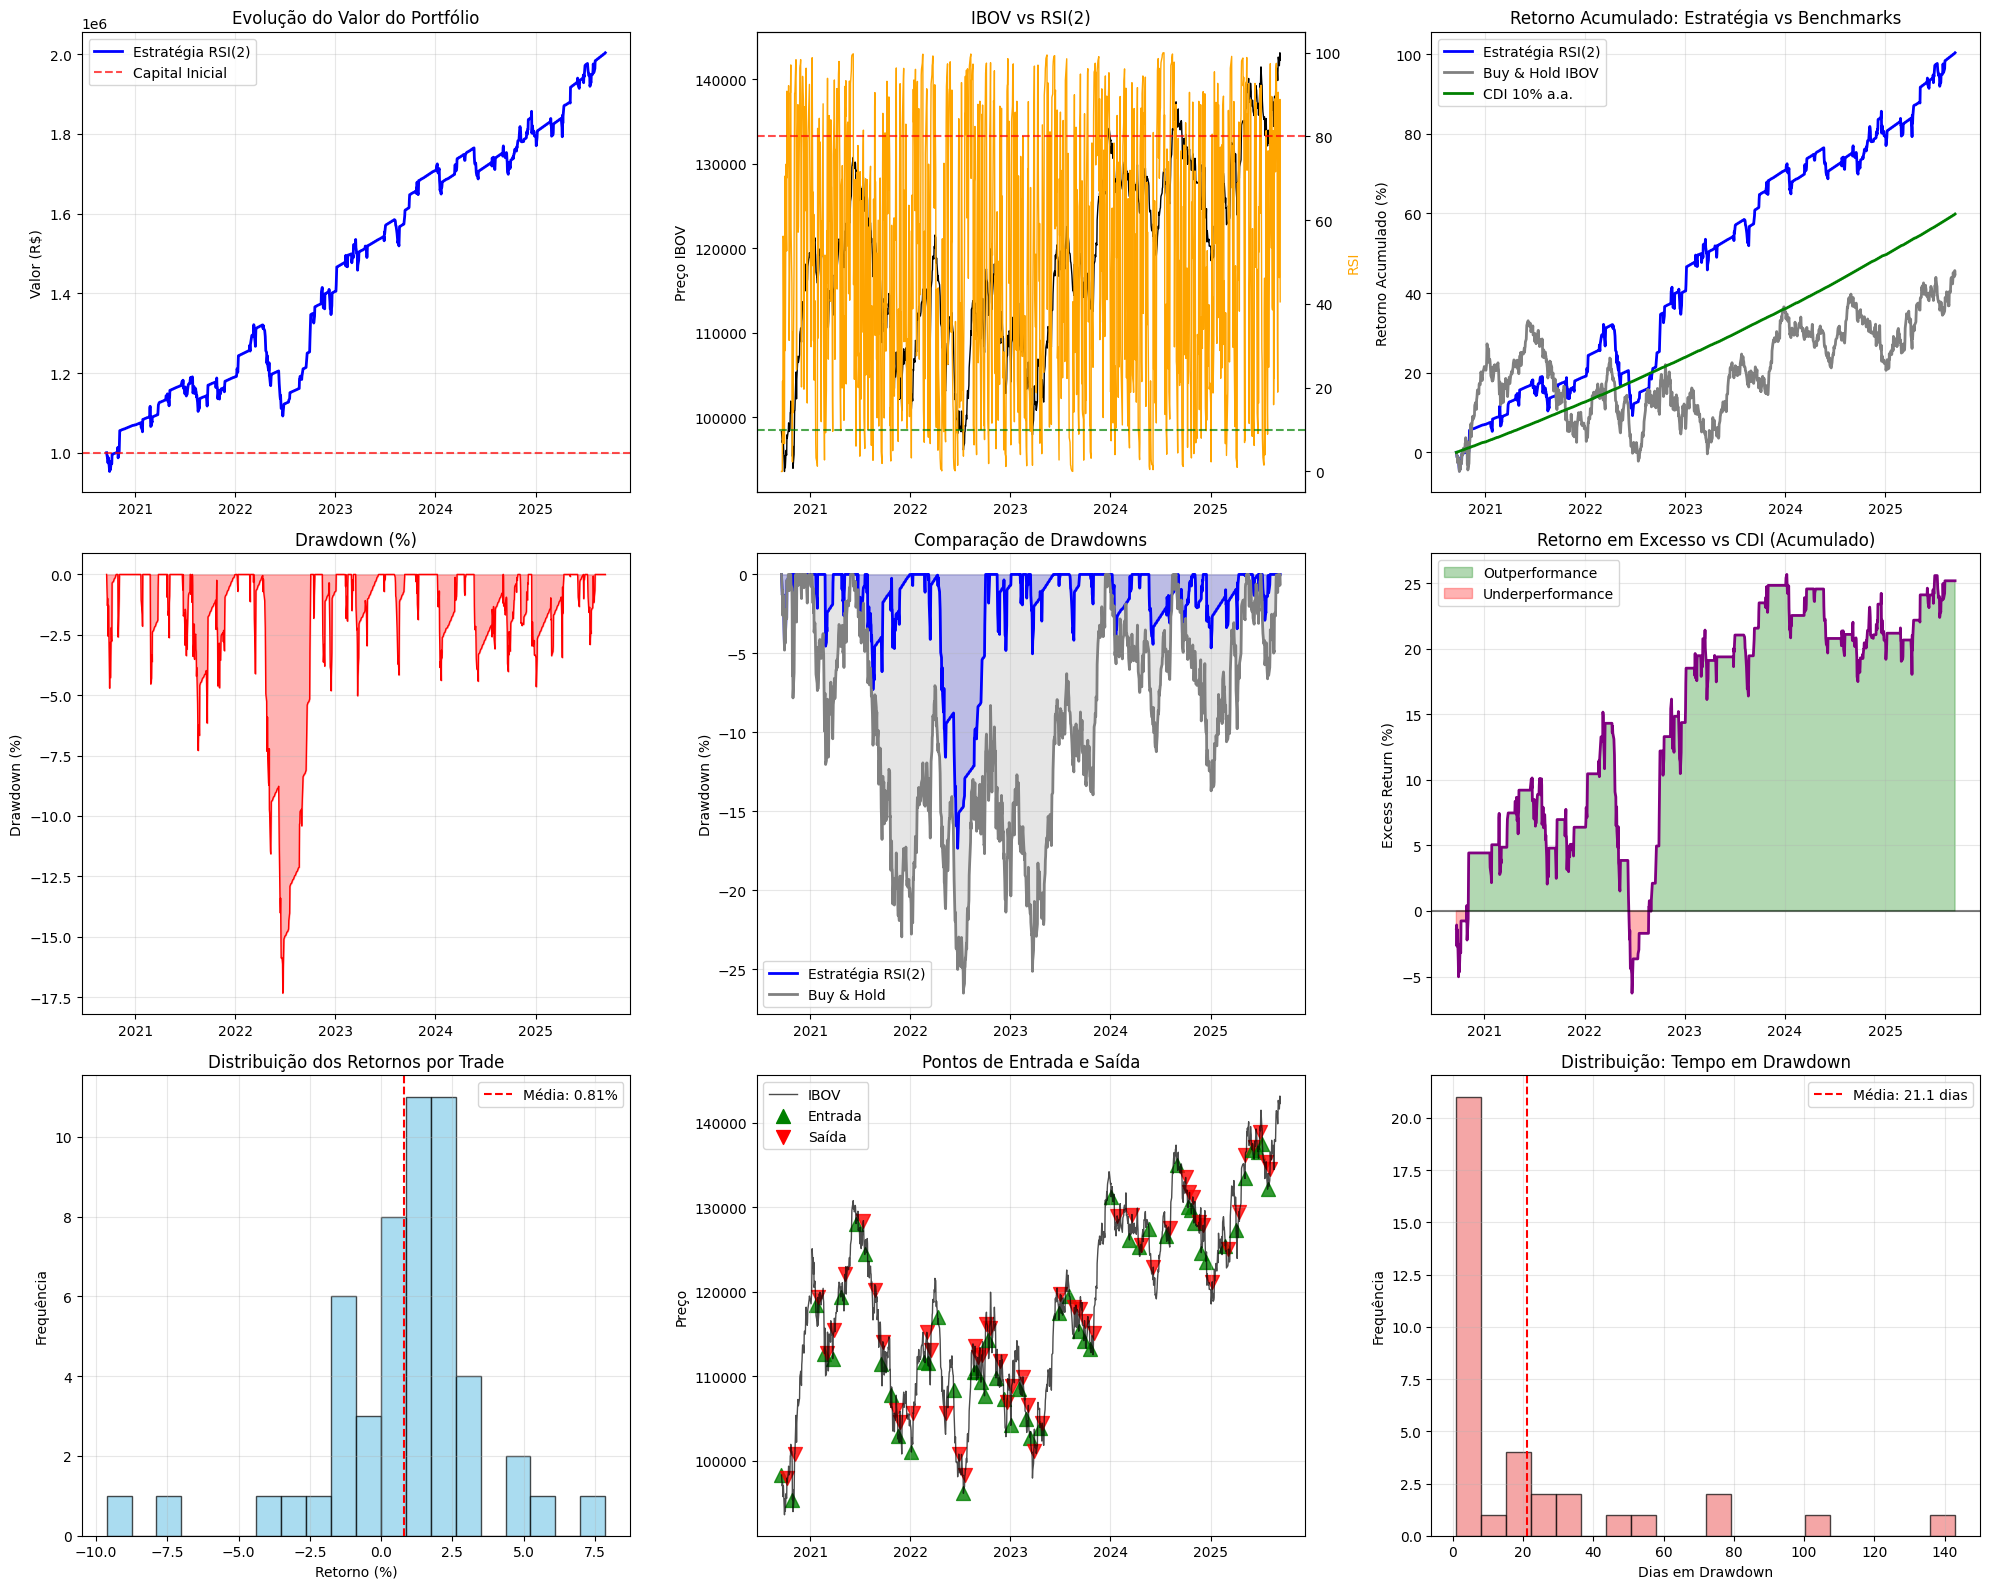

In [67]:
backtester.plot_results()

In [68]:
bnh_final_value = ibov['Close'].iloc[-1] / ibov['Close'].iloc[0] * backtester.initial_capital
bnh_return = (bnh_final_value - backtester.initial_capital) / backtester.initial_capital * 100

print(f"COMPARAÇÃO COM BUY & HOLD:")
print(f"Retorno Buy & Hold: {bnh_return:.2f}%")
print(f"Retorno Estratégia RSI(2): {metrics['Total Return (%)']:.2f}%")
print(f"Excesso de retorno: {metrics['Total Return (%)'] - bnh_return:.2f}%")

COMPARAÇÃO COM BUY & HOLD:
Retorno Buy & Hold: 44.75%
Retorno Estratégia RSI(2): 100.31%
Excesso de retorno: 55.56%


In [69]:
# Considerações sobre o carrego (CDI)
total_cdi_earnings = 0
completed_trades = [t for t in backtester.trades if 'exit_date' in t]

if completed_trades:
    print(f"INFORMAÇÕES SOBRE CARREGO (CDI 10% a.a.):")
    print(f"O dinheiro em caixa (quando fora do mercado) rendeu CDI de 10% ao ano")
    print(f"Isso contribuiu para a performance geral da estratégia")

print(f"A estratégia RSI(2) {'superou' if metrics['Total Return (%)'] > bnh_return else 'não superou'} o Buy & Hold")
print(f"Realizou {metrics['Number of Trades']} operações com {metrics['Accuracy (%)']:.1f}% de acerto")
print(f"Máximo drawdown de {abs(metrics['Maximum Drawdown (%)']):.2f}% vs volatilidade de {metrics['Volatility (% anual)']:.2f}%")
print(f"Sharpe Ratio de {metrics['Sharpe Ratio']:.2f} ({'bom' if metrics['Sharpe Ratio'] > 1 else 'pode melhorar' if metrics['Sharpe Ratio'] > 0 else 'ruim'})")


INFORMAÇÕES SOBRE CARREGO (CDI 10% a.a.):
O dinheiro em caixa (quando fora do mercado) rendeu CDI de 10% ao ano
Isso contribuiu para a performance geral da estratégia
A estratégia RSI(2) superou o Buy & Hold
Realizou 52 operações com 73.1% de acerto
Máximo drawdown de 17.33% vs volatilidade de 10.38%
Sharpe Ratio de 0.01 (pode melhorar)
